In [56]:
import os, pandas as pd, numpy as np

# ✅ Step 1: Define project folder for all outputs
PROJECT_DIR = r"C:\Users\vsanu\OneDrive\Desktop\telco-churn-eda"
os.makedirs(PROJECT_DIR, exist_ok=True)

print("Project folder set to:", PROJECT_DIR)

Project folder set to: C:\Users\vsanu\OneDrive\Desktop\telco-churn-eda


In [57]:
# Telco Churn: Load Excel & standardize columns
import os, pandas as pd, numpy as np

# ⬇️ put your real path here
EXCEL_PATH = r"C:\Users\vsanu\OneDrive\Desktop\telco-churn-eda\data\Telco_customer_churn.xlsx"

assert os.path.exists(EXCEL_PATH), f"File not found: {EXCEL_PATH}"

# Load (first sheet) and standardize column names
df = pd.read_excel(EXCEL_PATH)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Drop common stray index cols if present
for stray in ["Unnamed:_0", "Unnamed:_1", "index", "Index"]:
    if stray in df.columns:
        df = df.drop(columns=[stray])

print(df.shape)
df.head()


(7043, 33)


,CustomerID,Count,Country,State,City,Zip_Code,Lat_Long,Latitude,Longitude,Gender,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,Churn_Value,Churn_Score,CLTV,Churn_Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [58]:
# Trim spaces in text columns
obj_cols = df.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

# Normalize Yes/No style (only applies if the column exists)
yn_cols = [
    "Partner","Dependents","PhoneService","PaperlessBilling","Churn",
    "MultipleLines","OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies"
]
for c in [col for col in yn_cols if col in df.columns]:
    df[c] = df[c].str.title()

df.head(3)


,CustomerID,Count,Country,State,City,Zip_Code,Lat_Long,Latitude,Longitude,Gender,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,Churn_Value,Churn_Score,CLTV,Churn_Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [59]:
# Rename IBM Telco (underscored) → canonical names
rename_map = {
    "Tenure_Months": "tenure",
    "Monthly_Charges": "MonthlyCharges",
    "Total_Charges": "TotalCharges",
    "Senior_Citizen": "SeniorCitizen",
    "Churn_Label": "ChurnLabel",
    "Churn_Value": "ChurnValue",
    "Phone_Service": "PhoneService",
    "Multiple_Lines": "MultipleLines",
    "Internet_Service": "InternetService",
    "Online_Security": "OnlineSecurity",
    "Online_Backup": "OnlineBackup",
    "Device_Protection": "DeviceProtection",
    "Tech_Support": "TechSupport",
    "Streaming_TV": "StreamingTV",
    "Streaming_Movies": "StreamingMovies",
    "Paperless_Billing": "PaperlessBilling",
    "Payment_Method": "PaymentMethod",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
list(df.columns)[:20]



['CustomerID',
 'Count',
 'Country',
 'State',
 'City',
 'Zip_Code',
 'Lat_Long',
 'Latitude',
 'Longitude',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection']

In [60]:
# Make a single 'Churn' column from ChurnLabel/ChurnValue
import numpy as np
if "ChurnLabel" in df.columns:
    df["Churn"] = df["ChurnLabel"].astype(str).str.strip().str.title()
elif "ChurnValue" in df.columns:
    df["Churn"] = np.where(pd.to_numeric(df["ChurnValue"], errors="coerce") == 1, "Yes", "No")
else:
    raise ValueError("Need ChurnLabel or ChurnValue to derive 'Churn'")
df[["Churn"]].head()



,Churn
0,Yes
1,Yes
2,Yes
3,Yes
4,Yes


In [61]:
# Convert numerics
for col in ["MonthlyCharges", "TotalCharges", "tenure"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df[["MonthlyCharges","TotalCharges","tenure"]].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MonthlyCharges  7043 non-null   float64
 1   TotalCharges    7032 non-null   float64
 2   tenure          7043 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 165.2 KB


In [62]:
# SeniorCitizen → 0/1
if "SeniorCitizen" in df.columns:
    sc_txt = df["SeniorCitizen"].astype(str).str.strip().str.title()
    mapped = sc_txt.map({"Yes": 1, "No": 0})
    df["SeniorCitizen"] = mapped.where(mapped.notna(),
                                       pd.to_numeric(sc_txt, errors="coerce")).fillna(0).astype(int)
df[["SeniorCitizen"]].head()


,SeniorCitizen
0,0
1,0
2,0
3,0
4,0


In [63]:
# Backfill TotalCharges = MonthlyCharges * tenure (when possible)
if {"TotalCharges","MonthlyCharges","tenure"}.issubset(df.columns):
    mask = df["TotalCharges"].isna() & df["MonthlyCharges"].notna() & df["tenure"].notna()
    df.loc[mask, "TotalCharges"] = (df.loc[mask, "MonthlyCharges"] * df.loc[mask, "tenure"]).round(2)
df[["MonthlyCharges","tenure","TotalCharges"]].head()


,MonthlyCharges,tenure,TotalCharges
0,53.85,2,108.15
1,70.70,2,151.65
2,99.65,8,820.50
3,104.80,28,3046.05
4,103.70,49,5036.30


In [64]:
# Fill missings: numeric → median, categorical → mode
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode().iloc[0])

int(df.isna().sum().sum())


0

In [65]:
# Sanity checks
print("Columns OK:", {"tenure","MonthlyCharges","TotalCharges","SeniorCitizen","Churn"}.issubset(df.columns))
print("Nulls remaining:", int(df.isna().sum().sum()))
print("Churn distribution:\n", df["Churn"].value_counts(normalize=True).round(3))
df.head(3)


Columns OK: True
Nulls remaining: 0
Churn distribution:
 Churn
No     0.735
Yes    0.265
Name: proportion, dtype: float64


,CustomerID,Count,Country,State,City,Zip_Code,Lat_Long,Latitude,Longitude,Gender,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel,ChurnValue,Churn_Score,CLTV,Churn_Reason,Churn
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,Yes
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,Yes
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved,Yes


In [66]:
# 4 — Type casts + save a BI/model-ready CSV

# Ensure integers
if "SeniorCitizen" in df.columns:
    df["SeniorCitizen"] = df["SeniorCitizen"].astype(int)
if "tenure" in df.columns:
    df["tenure"] = df["tenure"].astype(int)

# Cast common categoricals (matching your dataset column names)
categorical_like = [
    "Gender","Partner","Dependents","PhoneService","MultipleLines",
    "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies","Contract",
    "PaperlessBilling","PaymentMethod","Churn"
]
for c in [col for col in categorical_like if c in df.columns]:
    df[c] = df[c].astype("category")

# Quick snapshot + save
print("Shape:", df.shape, "| Nulls:", int(df.isna().sum().sum()))
df.to_csv(os.path.join(PROJECT_DIR, "telco_churn_clean.csv"), index=False)
print("Saved -> telco_churn_clean.csv")


Shape: (7043, 34) | Nulls: 0
Saved -> telco_churn_clean.csv


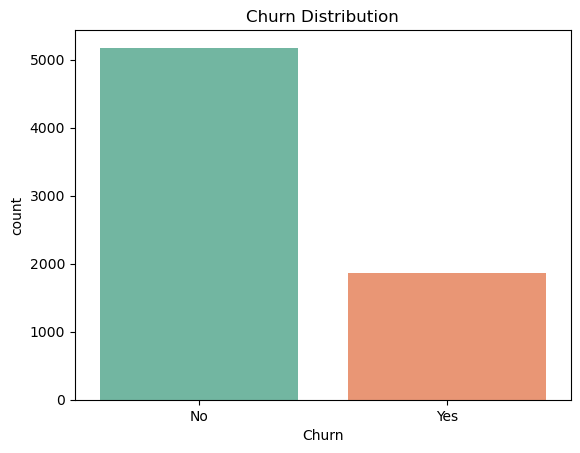

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Churn", hue="Churn", data=df, palette="Set2", legend=False)
plt.title("Churn Distribution")
plt.show()

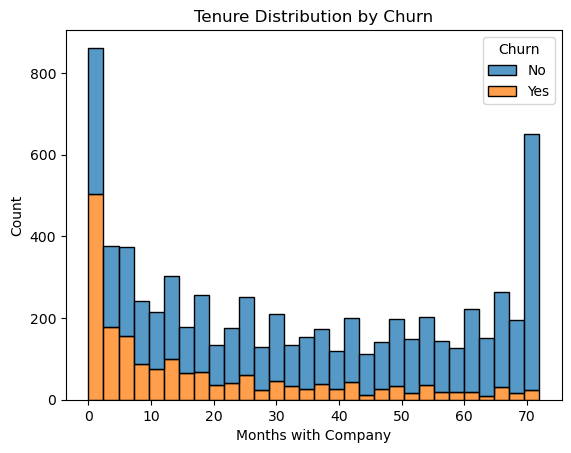

In [68]:
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, multiple="stack")
plt.title("Tenure Distribution by Churn")
plt.xlabel("Months with Company")
plt.show()

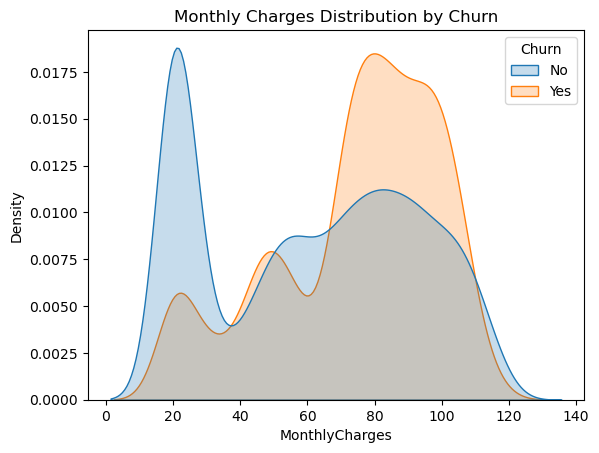

In [69]:
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", common_norm=False, fill=True)
plt.title("Monthly Charges Distribution by Churn")
plt.show()

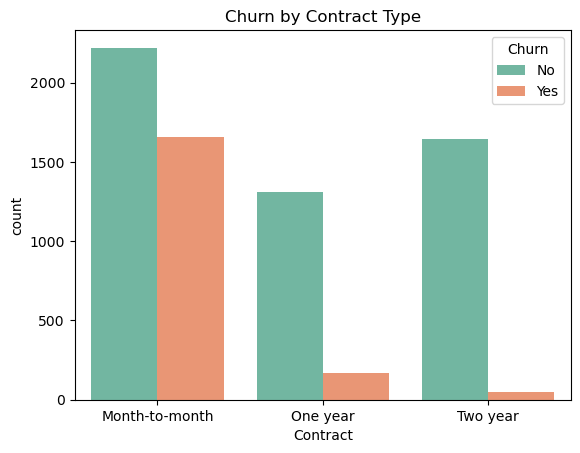

In [70]:
sns.countplot(x="Contract", hue="Churn", data=df, palette="Set2")
plt.title("Churn by Contract Type")
plt.show()

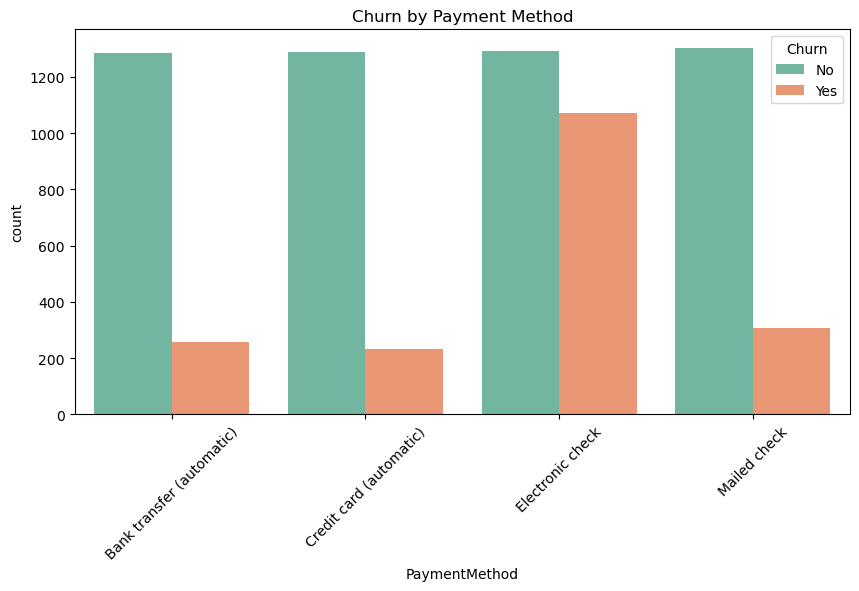

In [71]:
plt.figure(figsize=(10,5))
sns.countplot(x="PaymentMethod", hue="Churn", data=df, palette="Set2")
plt.title("Churn by Payment Method")
plt.xticks(rotation=45)
plt.show()

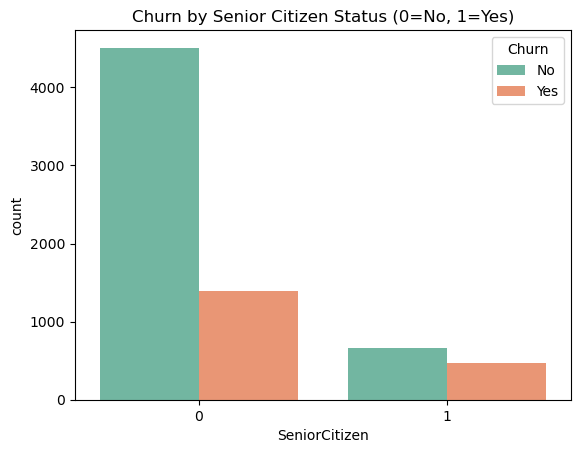

In [72]:
sns.countplot(x="SeniorCitizen", hue="Churn", data=df, palette="Set2")
plt.title("Churn by Senior Citizen Status (0=No, 1=Yes)")
plt.show()

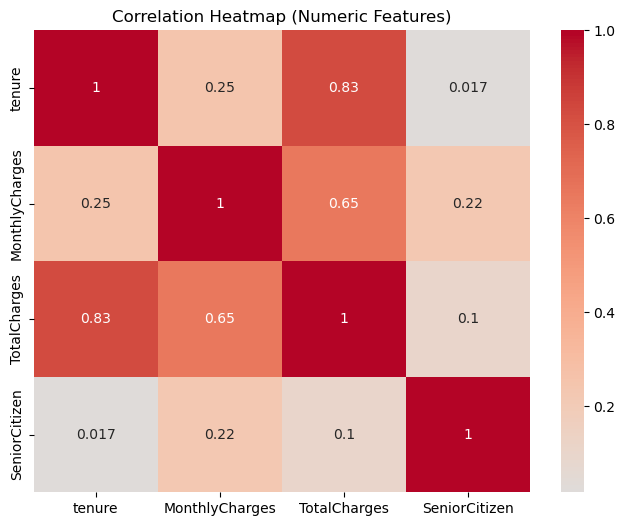

In [73]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["tenure","MonthlyCharges","TotalCharges","SeniorCitizen"]].corr(),
            annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [74]:
# 5 — Feature engineering + train/test split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df_fe = df.copy()

# Example engineered feature: average charge per tenure month
if {"TotalCharges","tenure"}.issubset(df_fe.columns):
    df_fe["AvgChargesPerTenure"] = (df_fe["TotalCharges"] / (df_fe["tenure"] + 1)).fillna(0)

# Define target & features
y = (df_fe["Churn"] == "Yes").astype(int)
X = df_fe.drop(columns=["Churn"])   # everything else is a feature

# Split into training and test (70/30), stratify keeps churn ratio balanced
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Churn rate in train:", y_train.mean().round(3))


Train shape: (4930, 34) | Test shape: (2113, 34)
Churn rate in train: 0.265


In [75]:
# 6 — Preprocessor (scale numerics + one-hot encode categoricals)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Prefer these columns; only keep ones that actually exist to avoid KeyErrors
preferred_num = ["tenure","MonthlyCharges","TotalCharges","SeniorCitizen","AvgChargesPerTenure"]
preferred_cat = [
    "Gender","Partner","Dependents","PhoneService","MultipleLines",
    "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies","Contract",
    "PaperlessBilling","PaymentMethod"
]

num_cols = [c for c in preferred_num if c in X_train.columns]
cat_cols = [c for c in preferred_cat if c in X_train.columns]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"  # ignore any leftover columns
)

print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)


Numerical features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'AvgChargesPerTenure']
Categorical features: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [76]:
# 7 — Modeling: train & compare LR / RF / (optional) XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
import pandas as pd

models = {
    "LogisticRegression": LogisticRegression(max_iter=600, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, random_state=42, class_weight="balanced_subsample"
    ),
}

# Optional: add XGBoost if available
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.06,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, tree_method="hist", eval_metric="logloss"
    )
except Exception as e:
    print("XGBoost not available, skipping:", e)

rows, fitted = [], {}
for name, base_model in models.items():
    clf = Pipeline(steps=[("prep", preprocessor), ("model", base_model)])
    clf.fit(X_train, y_train)
    fitted[name] = clf

    y_pred = clf.predict(X_test)
    # Try probas for ROC-AUC; if the model doesn't support it, set None
    try:
        y_proba = clf.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    except Exception:
        y_proba, roc = None, None

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    rows.append({
        "model": name,
        "accuracy": float((y_pred == y_test).mean()),
        "precision_macro": float(report["macro avg"]["precision"]),
        "recall_macro": float(report["macro avg"]["recall"]),
        "f1_macro": float(report["macro avg"]["f1-score"]),
        "recall_churners": float(report["1"]["recall"]),  # business-critical
        "roc_auc": None if roc is None else float(roc),
    })

results_df = pd.DataFrame(rows).sort_values(by=["recall_churners","roc_auc"], ascending=False)
results_df.round(4)


,model,accuracy,precision_macro,recall_macro,f1_macro,recall_churners,roc_auc
0,LogisticRegression,0.7525,0.7143,0.7638,0.7214,0.7879,0.8564
2,XGBoost,0.7875,0.7275,0.7011,0.7116,0.5169,0.8377
1,RandomForest,0.7894,0.7306,0.7001,0.7119,0.5098,0.8338


Confusion Matrix:
 [[1148  404]
 [ 119  442]]


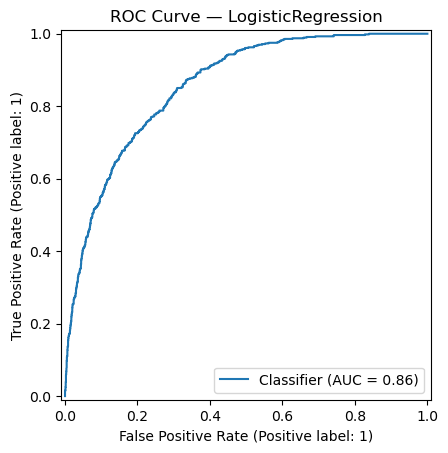

In [77]:
# 8 — Diagnostics for the best model
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

# Pick Logistic Regression (best recall on churners)
best_name = "LogisticRegression"
best_clf = fitted[best_name]

y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC curve
y_proba = best_clf.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve — {best_name}")
plt.show()

In [78]:
# 9 — Tune classification threshold (instead of default 0.5)
import numpy as np
from sklearn.metrics import precision_score, recall_score

y_scores = best_clf.predict_proba(X_test)[:,1]
thresholds = [0.3, 0.4, 0.5]

for t in thresholds:
    y_hat = (y_scores >= t).astype(int)
    rec = recall_score(y_test, y_hat)
    prec = precision_score(y_test, y_hat)
    print(f"Threshold {t}: Recall={rec:.3f}, Precision={prec:.3f}")

Threshold 0.3: Recall=0.918, Precision=0.444
Threshold 0.4: Recall=0.873, Precision=0.485
Threshold 0.5: Recall=0.788, Precision=0.522


In [79]:
# 10 — Save results + best model
import joblib

results_df.to_csv(os.path.join(PROJECT_DIR, "model_results.csv"), index=False)
joblib.dump(best_clf, os.path.join(PROJECT_DIR, "best_churn_model.joblib"))

print("Saved ->", os.path.join(PROJECT_DIR, "model_results.csv"),
      os.path.join(PROJECT_DIR, "best_churn_model.joblib"))

Saved -> C:\Users\vsanu\OneDrive\Desktop\telco-churn-eda\model_results.csv C:\Users\vsanu\OneDrive\Desktop\telco-churn-eda\best_churn_model.joblib


In [80]:
# Setup: Load DataFrame into SQLite (run once before the queries)
import sqlite3

sql_df = df.copy()
sql_df.columns = [c.replace(" ", "_") for c in sql_df.columns]  # make SQL-friendly

conn = sqlite3.connect(":memory:")  # in-memory database
sql_df.to_sql("TelcoChurn", conn, index=False, if_exists="replace")

7043

In [81]:
q1 = """
SELECT Contract,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct,
       COUNT(*) AS n_customers
FROM TelcoChurn
GROUP BY Contract
ORDER BY ChurnRatePct DESC;
"""
display(pd.read_sql_query(q1, conn))

,Contract,ChurnRatePct,n_customers
0,Month-to-month,42.71,3875
1,One year,11.27,1473
2,Two year,2.83,1695


In [82]:
q2 = """
SELECT PaymentMethod,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct
FROM TelcoChurn
GROUP BY PaymentMethod
ORDER BY ChurnRatePct DESC;
"""
display(pd.read_sql_query(q2, conn))

,PaymentMethod,ChurnRatePct
0,Electronic check,45.29
1,Mailed check,19.11
2,Bank transfer (automatic),16.71
3,Credit card (automatic),15.24


In [83]:
q3 = """
SELECT Churn, ROUND(AVG(tenure),2) AS AvgTenure
FROM TelcoChurn
GROUP BY Churn;
"""
display(pd.read_sql_query(q3, conn))

,Churn,AvgTenure
0,No,37.57
1,Yes,17.98


In [84]:
q4 = """
SELECT InternetService,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct,
       COUNT(*) AS n_customers
FROM TelcoChurn
GROUP BY InternetService
ORDER BY ChurnRatePct DESC;
"""
display(pd.read_sql_query(q4, conn))

,InternetService,ChurnRatePct,n_customers
0,Fiber optic,41.89,3096
1,DSL,18.96,2421
2,No,7.40,1526


In [85]:
q5 = """
SELECT OnlineSecurity,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct,
       COUNT(*) AS n_customers
FROM TelcoChurn
GROUP BY OnlineSecurity
ORDER BY ChurnRatePct DESC;
"""
display(pd.read_sql_query(q5, conn))

,OnlineSecurity,ChurnRatePct,n_customers
0,No,41.77,3498
1,Yes,14.61,2019
2,No internet service,7.40,1526


In [86]:
q6 = """
SELECT StreamingTV,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct,
       COUNT(*) AS n_customers
FROM TelcoChurn
GROUP BY StreamingTV
ORDER BY ChurnRatePct DESC;
"""
display(pd.read_sql_query(q6, conn))

,StreamingTV,ChurnRatePct,n_customers
0,No,33.52,2810
1,Yes,30.07,2707
2,No internet service,7.40,1526


In [87]:
q7 = """
SELECT Contract, PaperlessBilling,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct,
       COUNT(*) AS n_customers
FROM TelcoChurn
GROUP BY Contract, PaperlessBilling
ORDER BY ChurnRatePct DESC;
"""
display(pd.read_sql_query(q7, conn))

,Contract,PaperlessBilling,ChurnRatePct,n_customers
0,Month-to-month,Yes,48.30,2586
1,Month-to-month,No,31.50,1289
2,One year,Yes,14.75,800
3,One year,No,7.13,673
4,Two year,Yes,4.20,785
5,Two year,No,1.65,910


In [88]:
q8 = """
SELECT City,
       ROUND(AVG(CASE WHEN Churn='Yes' THEN 1.0 ELSE 0 END)*100,2) AS ChurnRatePct,
       COUNT(*) AS n_customers
FROM TelcoChurn
GROUP BY City
HAVING COUNT(*) > 20   -- only keep cities with at least 20 customers
ORDER BY ChurnRatePct DESC
LIMIT 5;
"""
display(pd.read_sql_query(q8, conn))

,City,ChurnRatePct,n_customers
0,Santa Rosa,45.83,24
1,Modesto,42.86,28
2,Santa Barbara,35.71,28
3,San Diego,33.33,150
4,Glendale,32.50,40


In [89]:
conn.close()

In [90]:
# Save artifacts
import joblib

# pick the best by churner recall, then roc_auc
best_row = results_df.sort_values(["recall_churners","roc_auc"], ascending=False).iloc[0]
best_name = best_row["model"]
best_clf = fitted[best_name]

results_df.to_csv("model_results.csv", index=False)
joblib.dump(best_clf, os.path.join(PROJECT_DIR, "best_churn_model.joblib"))

print(f"Saved -> model_results.csv, best_churn_model.joblib (best: {best_name})")

Saved -> model_results.csv, best_churn_model.joblib (best: LogisticRegression)


In [91]:
# Score the test set and create a ranked at-risk list
import pandas as pd
import numpy as np

# choose a business-friendly threshold; try 0.40 for higher recall
threshold = 0.40

# get probabilities for churn
y_scores = best_clf.predict_proba(X_test)[:, 1]
y_hat = (y_scores >= threshold).astype(int)

# build a handy dataframe with key business fields if present
cols_to_keep = [c for c in [
    "CustomerID","Contract","PaymentMethod","MonthlyCharges","TotalCharges","tenure","SeniorCitizen"
] if c in X_test.columns]

risk = pd.DataFrame(index=X_test.index)
risk["churn_probability"] = y_scores
risk["pred_churn"] = y_hat

for c in cols_to_keep:
    risk[c] = X_test[c]

# rank and filter to predicted churners
risk_sorted = risk.sort_values("churn_probability", ascending=False)
at_risk = risk_sorted[risk_sorted["pred_churn"] == 1].copy()

# save both
risk_sorted.to_csv(os.path.join(PROJECT_DIR, "scored_all_customers_testset.csv"), index=True)
at_risk.to_csv(os.path.join(PROJECT_DIR, "at_risk_customers_testset_threshold_0_40.csv"), index=True)

print(
    f"Saved -> scored_all_customers_testset.csv ({len(risk_sorted)}) and "
    f"at_risk_customers_testset_threshold_0_40.csv ({len(at_risk)})"
)
risk_sorted.head(10)

Saved -> scored_all_customers_testset.csv (2113) and at_risk_customers_testset_threshold_0_40.csv (1011)


,churn_probability,pred_churn,CustomerID,Contract,PaymentMethod,MonthlyCharges,TotalCharges,tenure,SeniorCitizen
886,0.982241,1,5178-LMXOP,Month-to-month,Electronic check,95.10,95.10,1,1
590,0.976648,1,7181-BQYBV,Month-to-month,Electronic check,102.45,102.45,1,0
1818,0.976628,1,0295-PPHDO,Month-to-month,Electronic check,95.45,95.45,1,0
1203,0.967169,1,1069-XAIEM,Month-to-month,Electronic check,85.05,85.05,1,1
623,0.967071,1,3722-WPXTK,Month-to-month,Electronic check,88.35,88.35,1,0
1135,0.966797,1,1455-ESIQH,Month-to-month,Electronic check,89.10,89.10,1,0
158,0.966632,1,0970-ETWGE,Month-to-month,Electronic check,89.55,89.55,1,0
991,0.966014,1,0684-AOSIH,Month-to-month,Electronic check,95.00,95.00,1,0
5906,0.962551,1,4912-PIGUY,Month-to-month,Electronic check,84.60,84.60,1,0
598,0.962393,1,7180-PISOG,Month-to-month,Electronic check,74.50,74.50,1,0


In [92]:
# Sweep thresholds to choose the trade-off you like
from sklearn.metrics import precision_score, recall_score, confusion_matrix

grid = np.linspace(0.2, 0.8, 13)
rows = []
for t in grid:
    yhat = (y_scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    rows.append({
        "threshold": round(t,2),
        "recall_churn": round(tp/(tp+fn),4) if (tp+fn)>0 else 0.0,
        "precision_churn": round(tp/(tp+fp),4) if (tp+fp)>0 else 0.0,
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn)
    })
pd.DataFrame(rows)

,threshold,recall_churn,precision_churn,tp,fp,tn,fn
0,0.20,0.9626,0.4003,540,809,743,21
1,0.25,0.9430,0.4249,529,716,836,32
2,0.30,0.9180,0.4440,515,645,907,46
3,0.35,0.9002,0.4646,505,582,970,56
4,0.40,0.8734,0.4847,490,521,1031,71
5,0.45,0.8378,0.4995,470,471,1081,91
6,0.50,0.7879,0.5225,442,404,1148,119
7,0.55,0.7576,0.5449,425,355,1197,136
8,0.60,0.7273,0.5659,408,313,1239,153
9,0.65,0.6845,0.5991,384,257,1295,177


In [93]:
# Export the clean dataset for dashboards (Power BI / Tableau)
df.to_csv("telco_churn_clean.csv", index=False)
print("Exported -> telco_churn_clean.csv")

Exported -> telco_churn_clean.csv


In [97]:
import os
print(os.getcwd())

C:\Users\vsanu


In [98]:
import os
print("File exists?", os.path.exists("telco_churn_clean.csv"))

File exists? True


In [99]:
df.to_csv(r"C:\Users\vsanu\OneDrive\Desktop\telco-churn-eda\telco_churn_clean.csv", index=False)